In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
GITHUB_CDN = "https://raw.githubusercontent.com/realamirhe/github-stargazer"

tens = range(1, 10)

js_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/js-{idx}.csv", tens)
py_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/py-{idx}.csv", tens)
first_chunk_url =  f"{GITHUB_CDN}/master/data/datas.csv"
second_chunk_url =  f"{GITHUB_CDN}/master/data/datas-2.csv"

data_urls = [*js_repo_urls, *py_repo_urls, first_chunk_url, second_chunk_url]

In [6]:
datas = pd.concat(list(map(pd.read_csv, data_urls)))
datas = datas.select_dtypes(exclude=['object'])
datas = datas.reset_index()
datas = datas.drop_duplicates()
datas = datas.drop(columns=['index', 'Unnamed: 0', 'score'], axis=1)
datas = datas.replace({ False: 0, True: 1 })
datas.head()

,private,owner.public_repos,owner.public_gists,owner.followers,owner.following,fork,forks,size,stargazers_count,watchers_count,...,has_pages,has_discussions,forks_count,archived,disabled,open_issues_count,allow_forking,is_template,web_commit_signoff_required,watchers
0,0,64,62,23302,11,0,540,7954,1962,1962,...,0,0,540,0,0,30,1,0,0,1962
1,0,274,758,10063,11,0,61,3462,435,435,...,0,0,61,0,0,13,1,0,0,435
2,0,50,0,11,0,0,605,168196,3031,3031,...,0,0,605,0,0,15,1,0,0,3031
3,0,64,62,23302,11,0,516,2639,2200,2200,...,1,0,516,0,0,247,1,0,0,2200
4,0,58,50,195,16,0,7,192,68,68,...,0,0,7,0,0,1,1,0,0,68


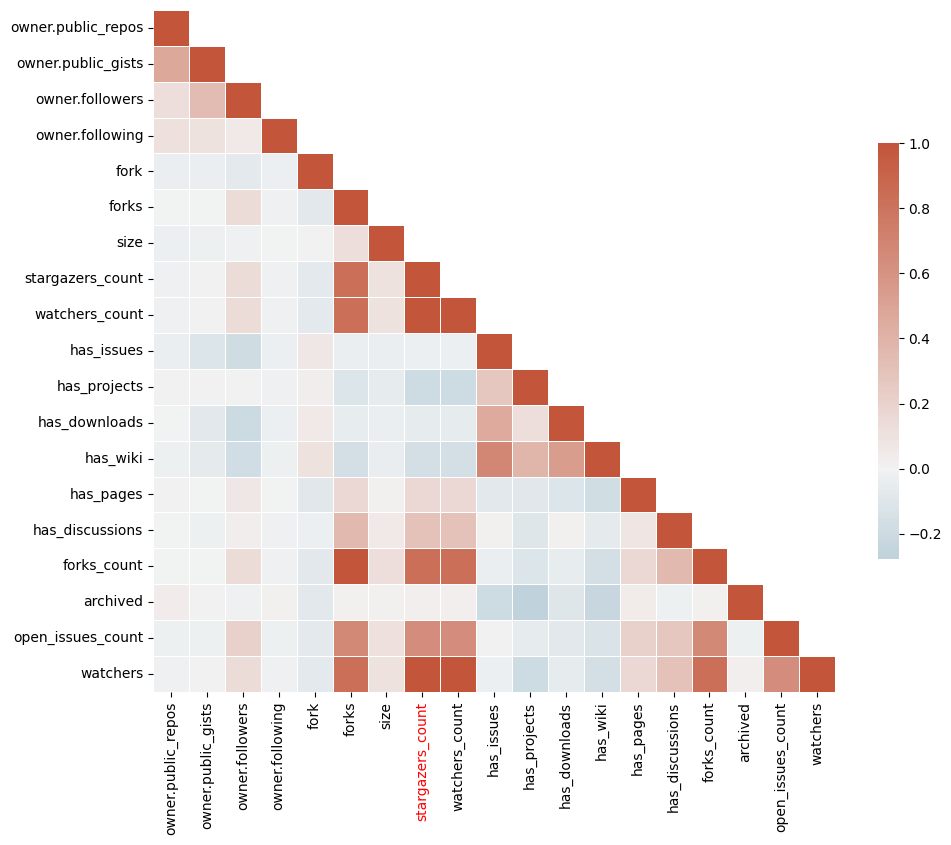

In [7]:
keep = [c for c in list(datas) if len(datas[c].unique()) > 1]
corr = datas[keep].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax1 = sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .6})

for tick_label in ax1.xaxis.get_ticklabels():
  tick_label.set_color('red' if tick_label.get_text() == 'stargazers_count' else 'black')

In [57]:
startruck_ranges = (-np.inf,2.5,np.inf)
startruck_labels = [0, 1]

y = datas['stargazers_count']
y = np.log(y + 0.001)
y = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
y = y.astype(np.float64)

# remove high correlated datas
X = datas.drop(columns=['stargazers_count', 'watchers', 'watchers_count'])

## PCA

In [58]:
from sklearn.decomposition import PCA

In [59]:
n_components = 2
pca = PCA(n_components)
pca.fit(X)

print(f"Only {n_components} component can cover {np.sum(pca.explained_variance_ratio_)*100:.3f}% of data")

Only 2 component can cover 99.984% of data


In [60]:
from sklearn.model_selection import train_test_split
X_pca_transformed = pca.transform(X)
x_train, x_test, y_train, y_test = train_test_split(
    X_pca_transformed, 
    y, 
    test_size=0.2, 
    random_state=42
)

## TSNE

In [61]:
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter

In [64]:
# https://github.com/community/community/discussions/20560
y = datas['stargazers_count']
startruck_ranges = (0, 1, 16, 128, 512, 4096, 16384, 65536, 262144)
startruck_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
startruck_missing_value = len(startruck_labels) + 1
y_cutted = y_cutted.cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)

c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE: 23 sec


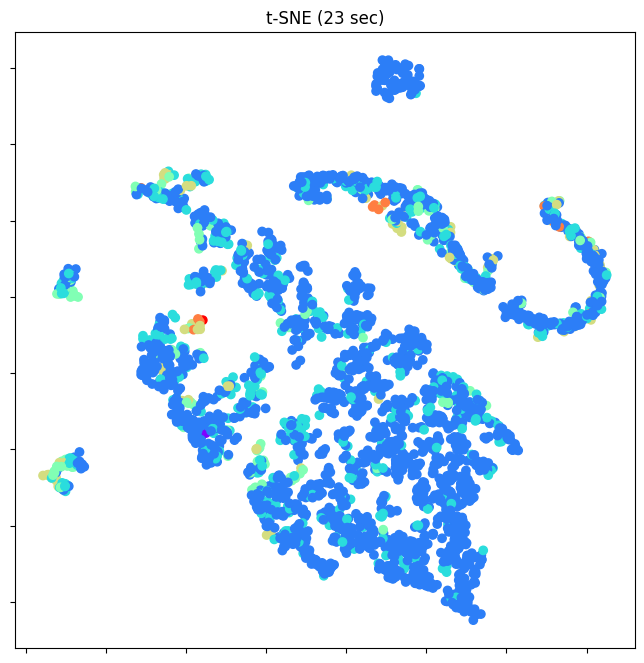

In [65]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

In [66]:
def cut_y(y):
  # https://github.com/community/community/discussions/20560
  startruck_ranges = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,64,128,512,1024,2048,4096)
  startruck_labels = list(range(len(startruck_ranges) -1))
  y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
  startruck_missing_value = len(startruck_labels) + 1
  y_cutted = y_cutted.astype(np.float64)
  y_cutted[np.isnan(y_cutted)] = startruck_missing_value
  return y_cutted.astype(np.int8)
  

y = datas['stargazers_count']
y_cutted = cut_y(y)

In [67]:
y_cutted

0       21
1       19
2       22
3       22
4       18
        ..
4827    17
4828     3
4829    19
4830     1
4831     2
Name: stargazers_count, Length: 3203, dtype: int8

<AxesSubplot: >

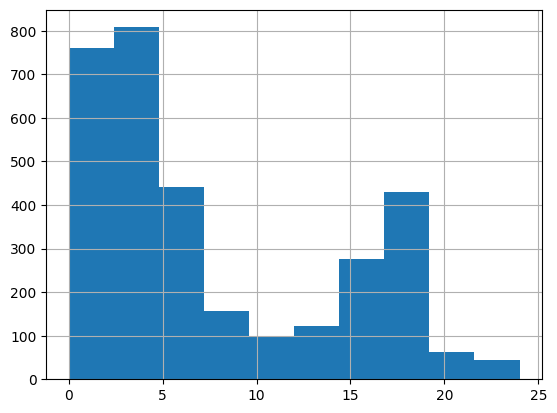

In [68]:
y_cutted.hist()

c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE: 23 sec


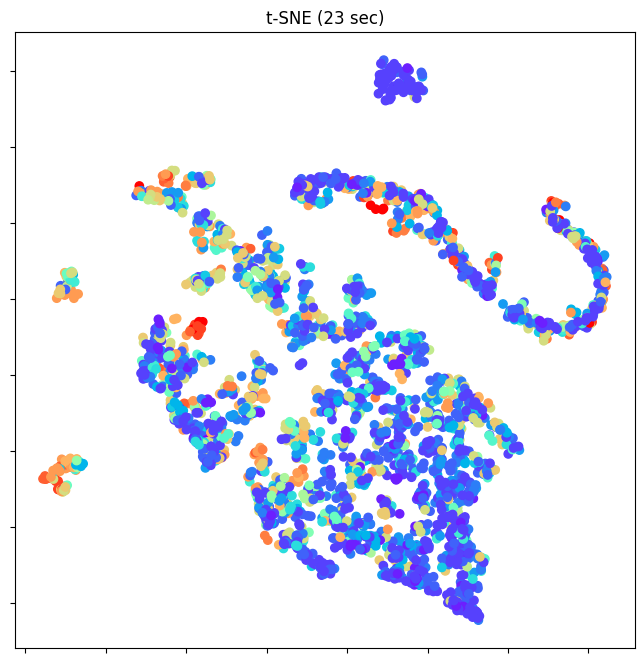

In [69]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

## KNN

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

Text(0.5, 1.0, '5-fold cross validation for KNN')

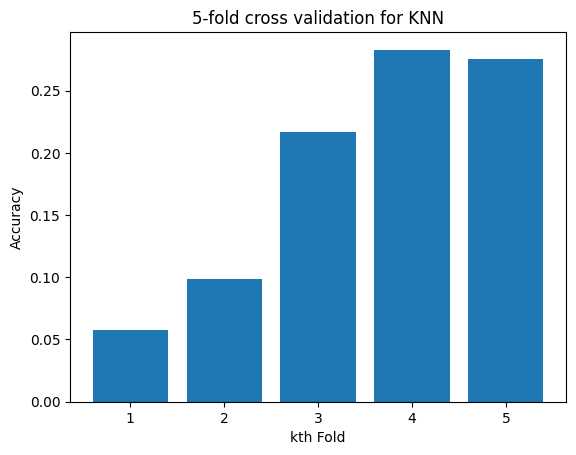

In [71]:
# k-fold
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=5)
# model
knn = KNeighborsClassifier(n_neighbors=4)
# bechmark
acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = knn.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = clf.predict(X.iloc[test_index])
    y_pred = cut_y(y_pred)
    y_true = y.iloc[test_index]
    acc.append(accuracy_score(y_true, y_pred))

plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for KNN')

### Normalizing datas

In [72]:
X_norm = X.copy()

for column in X_norm.columns:
    X_norm[column] = (X_norm[column] - X_norm[column].min()) / (X_norm[column].max() - X_norm[column].min())    
X_norm=X_norm.dropna(axis='columns')
print("Shape of Normalized Datas: ",str(X_norm.shape))


Shape of Normalized Datas:  (3203, 16)


In [73]:
y = datas['stargazers_count']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_norm, y, test_size=0.2, random_state=0)


## Feature Selection

### Best Features by Random Forest Regression

[Index(['forks', 'forks_count', 'open_issues_count'], dtype='object')]


<AxesSubplot: title={'center': 'Coefficients of Features in Random Forest Regressor '}>

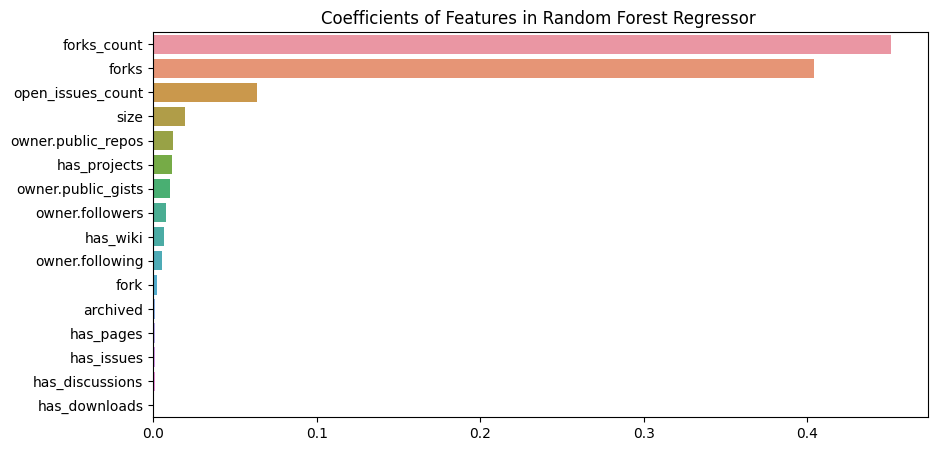

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

feature_names = X_norm.columns
best_feature_names_RF = []
rf_reg = RandomForestRegressor(max_depth=10, random_state=0)
rf_reg.fit(X_train_n,y_train_n)

rf_sfm = SelectFromModel(rf_reg)
rf_sfm.fit(X_train_n, y_train_n)
best_feature_names_RF.append(feature_names[rf_sfm.get_support()])
print(best_feature_names_RF)

f_i = list(zip(feature_names,rf_reg.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Random Forest Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])


### Best Features by Random Linear Regression

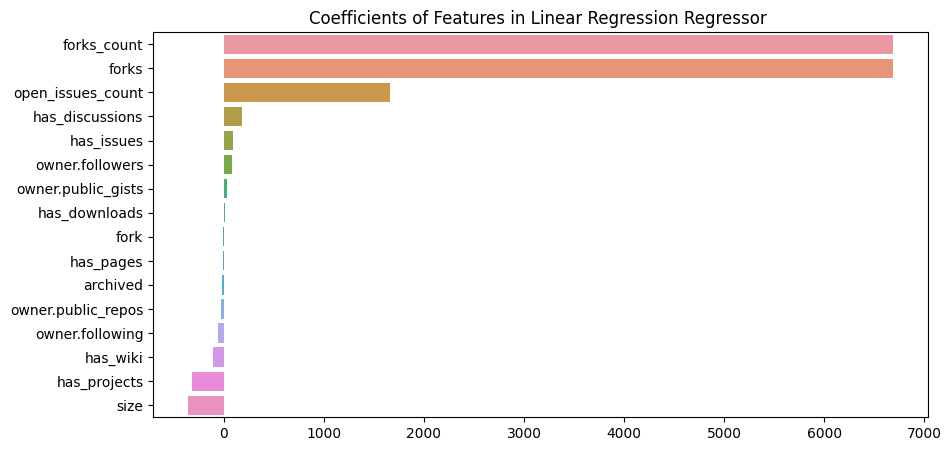

In [75]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_n, y_train_n)

f_i = list(zip(X_norm.columns,lin_reg.coef_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Linear Regression Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])
plt.show()

## Regression Models

### Decision Tree Regression

Decision Tree R2 score:  0.6593109637485559
Decision Tree MSE:  253215.11935560757
Decision Tree MAE:  50.070072802912115
Decision Tree 5-Fold R2 score N(0.5743940904407963, 0.10822356101755765)


<AxesSubplot: title={'center': 'Coefficients of Features in Decision Tree Regressor '}>

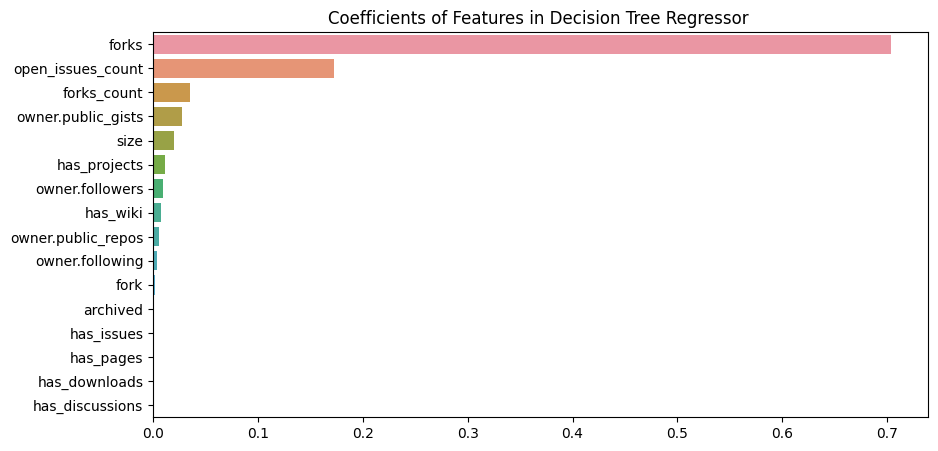

In [76]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor

dt_ergressor = DecisionTreeRegressor(criterion="squared_error")
dt_ergressor.fit(X_train_n, y_train_n)
y_pred = dt_ergressor.predict(X_test_n)
print("Decision Tree R2 score: ",dt_ergressor.score(X_test_n, y_test_n))
print("Decision Tree MSE: ",metrics.mean_squared_error(y_test_n, y_pred))
print("Decision Tree MAE: ",metrics.mean_absolute_error(y_test_n, y_pred))
cv = cross_val_score(dt_ergressor, X_norm, y, cv=5, scoring="r2")
print(f"Decision Tree 5-Fold R2 score N({cv.mean()}, {cv.std()})")

f_i = list(zip(X_norm.columns,dt_ergressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Decision Tree Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])



### KNN Regression

In [77]:
from sklearn.neighbors import KNeighborsRegressor
knn_ergressor = KNeighborsRegressor(n_neighbors=5)
knn_ergressor.fit(X_train_n,y_train_n)
y_pred = knn_ergressor.predict(X_test_n)
print("KNN R2 score: ",knn_ergressor.score(X_test_n,y_test_n))
print("KNN MSE: ",metrics.mean_squared_error(y_test_n,y_pred))
print("KNN MAE: ",metrics.mean_absolute_error(y_test_n,y_pred))

cv = cross_val_score(knn_ergressor, X_norm, y, cv=5,scoring="r2")
print(f"KNN 5-Fold R2 score N({cv.mean()}, {cv.std()})")


KNN R2 score:  0.34860396322041176
KNN MSE:  484146.2672698909
KNN MAE:  86.71170046801873
KNN 5-Fold R2 score N(0.014807706145717914, 0.8334974909595793)


### MLP Regression

In [80]:
from sklearn.neural_network import MLPRegressor
params = {
  "hidden_layer_sizes":(300,100,50),
  "activation":"relu",
  "solver":"adam",
  "learning_rate":"adaptive", 
  "learning_rate_init":0.3,
}
MLP_ergressor = MLPRegressor(**params)
MLP_ergressor.fit(X_train_n,y_train_n)
y_pred_MLPRegressor = MLP_ergressor.predict(X_test_n)
cv=cross_val_score(MLP_ergressor,X=X_norm,y=y,cv=5,scoring="r2")
print("MLP R2 score: ",MLP_ergressor.score(X_test_n,y_test_n))
print(f"MLP 5-Fold R2 score N({cv.mean()}, {cv.std()})")
print("MLP MSE: ",metrics.mean_squared_error(y_test_n,y_pred_MLPRegressor))
print("MLP MAE: ",metrics.mean_absolute_error(y_test_n,y_pred_MLPRegressor))


MLP R2 score:  0.558509520898897
MLP 5-Fold R2 score N(-0.5134095113152447, 1.2059708989458189)
MLP MSE:  328135.19797990366
MLP MAE:  95.69281442492114


### AdaBoost Regressor

AdaBoost R2 score: 0.5363370803489558
AdaBoost MSE: 344614.7338112675
AdaBoost MAE: 153.07002848338288
AdaBoost 5-Fold R2 score N(0.05032177125659165, 1.2436640542017898)


<AxesSubplot: title={'center': 'Coefficients of Features in AdaBoost Regressor '}>

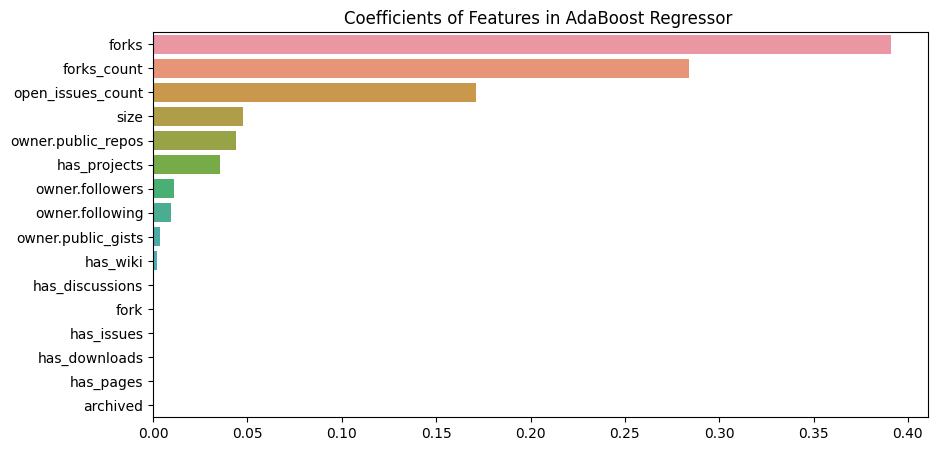

In [81]:
from sklearn.ensemble import AdaBoostRegressor

AdaBoost_regressor = AdaBoostRegressor(n_estimators=50,random_state=0)
AdaBoost_regressor.fit(X_train_n,y_train_n)
y_pred = AdaBoost_regressor.predict(X_test_n)
print("AdaBoost R2 score:", AdaBoost_regressor.score(X_test_n, y_test_n))
print("AdaBoost MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("AdaBoost MAE:", metrics.mean_absolute_error(y_test_n, y_pred))

scores = cross_val_score(AdaBoost_regressor, X_norm, y, cv=5,scoring="r2")
print(f"AdaBoost 5-Fold R2 score N({scores.mean()}, {scores.std()})")

f_i = list(zip(X_norm.columns,AdaBoost_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in AdaBoost Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])


### Bagging (Ensemble Learning)

In [82]:
from sklearn.ensemble import BaggingRegressor

bagging_regressor = BaggingRegressor(n_estimators=50,random_state=0,bootstrap=False)
bagging_regressor.fit(X_train_n,y_train_n)
y_pred = bagging_regressor.predict(X_test_n)
print("Bagging (Ensemble Learning) R2 score:", bagging_regressor.score(X_test_n, y_test_n))
print("Bagging (Ensemble Learning) MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("Bagging (Ensemble Learning) MAE:", metrics
      .mean_absolute_error(y_test_n, y_pred))
scores = cross_val_score(bagging_regressor, X_norm, y, cv=5,scoring="r2")
print(f"Bagging 5-Fold R2 score N({scores.mean()}, {scores.std()})")



Bagging (Ensemble Learning) R2 score: 0.6367494841648557
Bagging (Ensemble Learning) MSE: 269983.80615716754
Bagging (Ensemble Learning) MAE: 47.15565782631306
Bagging 5-Fold R2 score N(0.529822289149744, 0.1640004249530775)


### XGBoost Regressor

[19:15:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost R2 score: 0.6056514614387082
XGBoost MSE: 293097.2283646057
XGBoost MAE: 54.5994863401802
[19:15:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor

<AxesSubplot: title={'center': 'XGBoost of Features in AdaBoost Regressor '}>

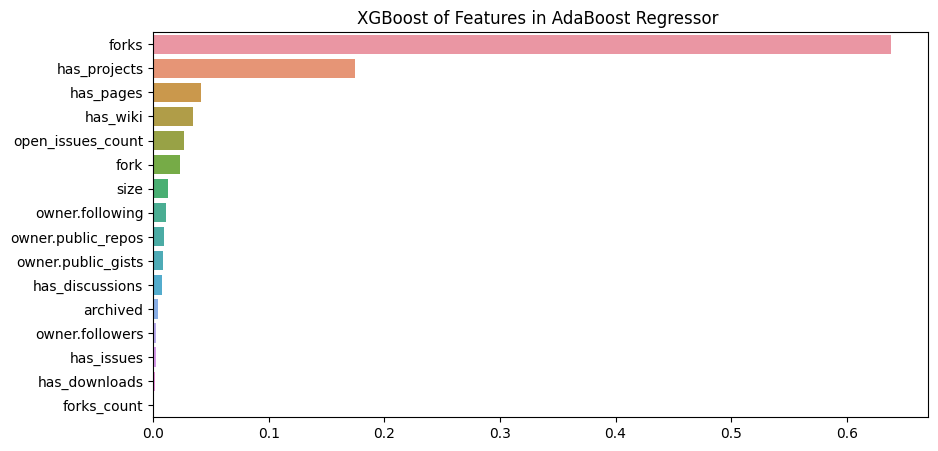

In [83]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_regressor.fit(X_train_n, y_train_n)
y_pred = xgb_regressor.predict(X_test_n)
print("XGBoost R2 score:", xgb_regressor.score(X_test_n, y_test_n))
print("XGBoost MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("XGBoost MAE:", metrics.mean_absolute_error(y_test_n, y_pred))

scores = cross_val_score(xgb_regressor, X_norm, y, cv=5,scoring="r2")
print(f"XGBoost 5-Fold R2 score N({scores.mean()}, {scores.std()})")

f_i = list(zip(X_norm.columns,xgb_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('XGBoost of Features in AdaBoost Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])


# Classification Models

## A) Implement Classification on output of Regressions


### Random Forest Classification on output of Random Forest Regression

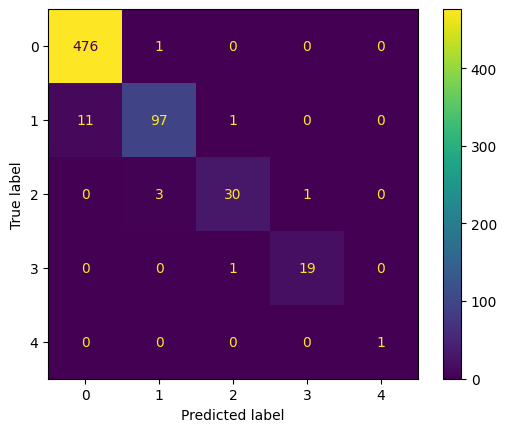

========================Classification Metrics======================
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       477
           2       0.96      0.89      0.92       109
           3       0.94      0.88      0.91        34
           4       0.95      0.95      0.95        20
           5       1.00      1.00      1.00         1

    accuracy                           0.97       641
   macro avg       0.97      0.94      0.95       641
weighted avg       0.97      0.97      0.97       641

5-Fold accuracy N(0.9600336388455538, 0.007829063261764059)


In [84]:
from sklearn.metrics import classification_report
y_pred_rf_reg=rf_reg.predict(X_norm)

y_cat = pd.cut(y_pred_rf_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(min_samples_split=10,n_estimators=10,criterion='entropy',bootstrap=False,warm_start=True) 
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)


cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

### Logestic Regression Classification on output of Linear Regression

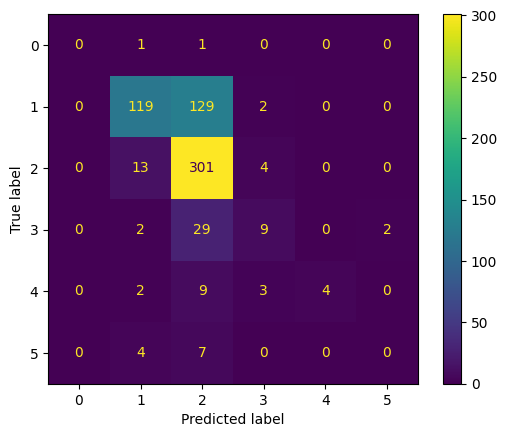

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.84      0.48      0.61       250
           2       0.63      0.95      0.76       318
           3       0.50      0.21      0.30        42
           4       1.00      0.22      0.36        18
           9       0.00      0.00      0.00        11

    accuracy                           0.68       641
   macro avg       0.50      0.31      0.34       641
weighted avg       0.70      0.68      0.64       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

5-Fold accuracy N(0.6687353744149765, 0.02724508036245872)


In [85]:
y_pred_lin_reg=lin_reg.predict(X_norm)

y_cat = pd.cut(y_pred_lin_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42,solver="liblinear") 
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

### Decision Tree Classification on output of Decision Tree Regression

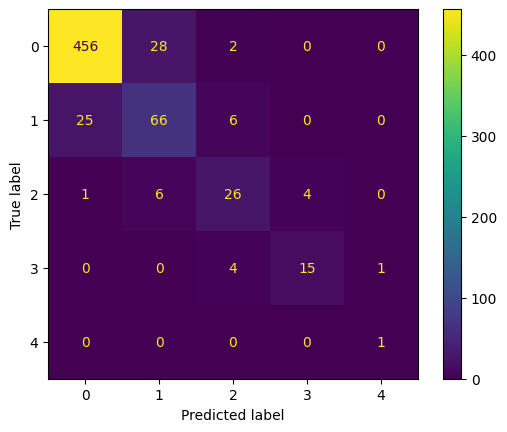

========================Classification Metrics======================
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       486
           2       0.66      0.68      0.67        97
           3       0.68      0.70      0.69        37
           4       0.79      0.75      0.77        20
           5       0.50      1.00      0.67         1

    accuracy                           0.88       641
   macro avg       0.72      0.81      0.75       641
weighted avg       0.88      0.88      0.88       641

5-Fold accuracy N(0.8357941692667706, 0.0421528348284341)


c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [86]:
y_pred_dt_reg=dt_ergressor.predict(X_norm)

y_cat = pd.cut(y_pred_dt_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy") 
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


### KNN Classification on output of KNN Regression

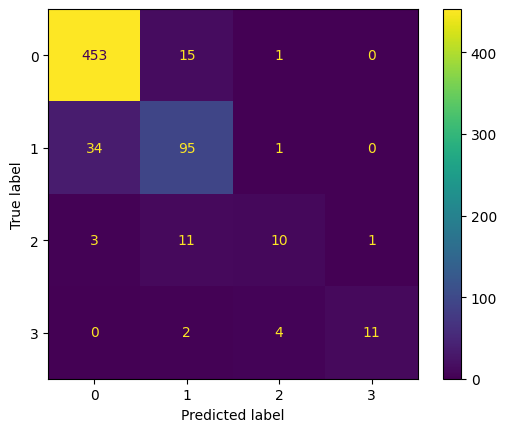

========================Classification Metrics======================
              precision    recall  f1-score   support

           1       0.92      0.97      0.94       469
           2       0.77      0.73      0.75       130
           3       0.62      0.40      0.49        25
           4       0.92      0.65      0.76        17

    accuracy                           0.89       641
   macro avg       0.81      0.69      0.74       641
weighted avg       0.88      0.89      0.88       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


5-Fold accuracy N(0.8629494929797191, 0.016751315450706447)


In [87]:
y_pred_Knn_reg=knn_ergressor.predict(X_norm)

y_cat = pd.cut(y_pred_Knn_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5) 
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


### MLP Classification on output of MLP Regression

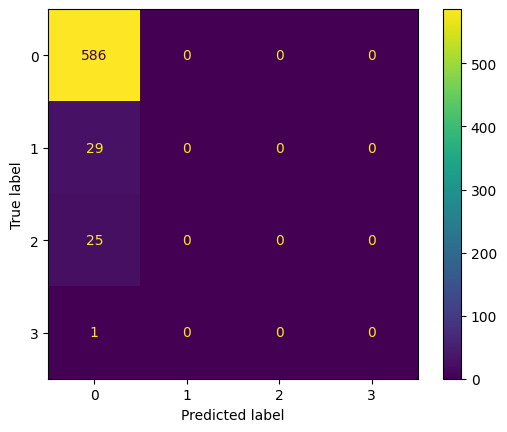

========================Classification Metrics======================
              precision    recall  f1-score   support

           2       0.91      1.00      0.96       586
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00         1

    accuracy                           0.91       641
   macro avg       0.23      0.25      0.24       641
weighted avg       0.84      0.91      0.87       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

5-Fold accuracy N(0.9437909516380655, 0.032201080511748116)


In [88]:
y_pred_mlp_reg=MLP_ergressor.predict(X_norm)

y_cat = pd.cut(y_pred_mlp_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.neural_network import MLPClassifier
params = {
  "hidden_layer_sizes":(300,100,50),
  "activation":"relu",
  "solver":"adam",
  "learning_rate":"adaptive", 
  "learning_rate_init":0.3,
}
clf = MLPClassifier(**params)
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


### Adaboost Classification on output of Adaboost Regression

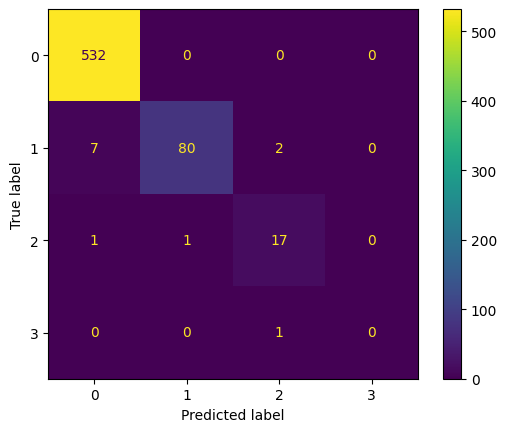

========================Classification Metrics======================
              precision    recall  f1-score   support

           2       0.99      1.00      0.99       532
           3       0.99      0.90      0.94        89
           4       0.85      0.89      0.87        19
           5       0.00      0.00      0.00         1

    accuracy                           0.98       641
   macro avg       0.71      0.70      0.70       641
weighted avg       0.98      0.98      0.98       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

5-Fold accuracy N(0.8296299726989078, 0.30718716511590294)


In [89]:
y_pred_adaboost_reg=AdaBoost_regressor.predict(X_norm)

y_cat = pd.cut(y_pred_adaboost_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=50)
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


### Bagging Classification on output of Bagging Regression

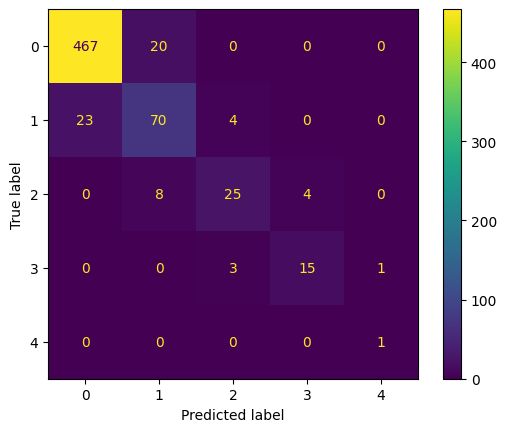

========================Classification Metrics======================
              precision    recall  f1-score   support

           1       0.95      0.96      0.96       487
           2       0.71      0.72      0.72        97
           3       0.78      0.68      0.72        37
           4       0.79      0.79      0.79        19
           5       0.50      1.00      0.67         1

    accuracy                           0.90       641
   macro avg       0.75      0.83      0.77       641
weighted avg       0.90      0.90      0.90       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


5-Fold accuracy N(0.8779285296411856, 0.038633874756986916)


In [90]:
y_pred_bagging_reg=bagging_regressor.predict(X_norm)

y_cat = pd.cut(y_pred_bagging_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)


from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(n_estimators=50)
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))

scores = cross_val_score(clf, X_norm, y_cat, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


### XGBoost Classification on output of XGBoost Regression

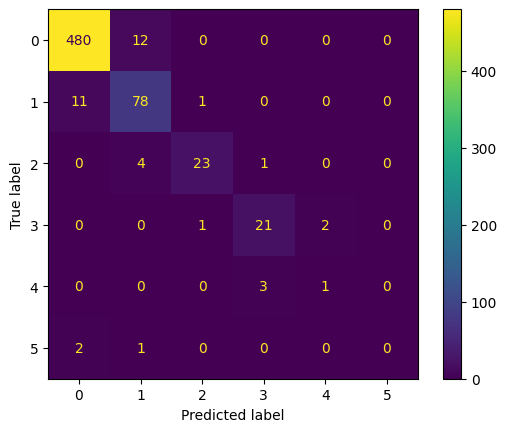

========================Classification Metrics======================
              precision    recall  f1-score   support

           1       0.97      0.98      0.97       492
           2       0.82      0.87      0.84        90
           3       0.92      0.82      0.87        28
           4       0.84      0.88      0.86        24
           5       0.33      0.25      0.29         4
           6       0.00      0.00      0.00         3

    accuracy                           0.94       641
   macro avg       0.65      0.63      0.64       641
weighted avg       0.94      0.94      0.94       641



c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [93]:
y_pred_XGB_reg=xgb_regressor.predict(X_norm)

y_cat = pd.cut(y_pred_XGB_reg, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_cat = y_cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_cat = le.fit_transform(y_cat)

X_train_n, X_test_n, y_train_cat, y_test_cat = train_test_split(X_norm, y_cat, test_size=0.2,shuffle=True)
clf = xgb.XGBClassifier()
clf.fit(X_train_n, y_train_cat) 
y_pred=clf.predict(X_test_n)

cm = metrics.confusion_matrix(y_test_cat, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test_cat, y_pred))




## B) Implement Classification on raw data


### B-1) Binary Classification

In [95]:
y = datas['stargazers_count']
startruck_ranges = (-np.inf,2.5,np.inf)
startruck_labels = [0, 1]
y_bin=np.log(y+0.001)
y_bin = pd.cut(y_bin, [i-1 for i in startruck_ranges], labels=startruck_labels)
y_bin=y_bin.astype(np.float64)

In [96]:
pca=PCA(n_components=2)
pca.fit(X)
print(np.sum(pca.explained_variance_ratio_))
xp=pca.transform(X)
x_train, x_test, y_train, y_test = train_test_split(xp, y_bin, test_size=0.2, random_state=42)

0.9998439005576629


### KNN

Text(0.5, 1.0, '5-fold cross validation for KNN')

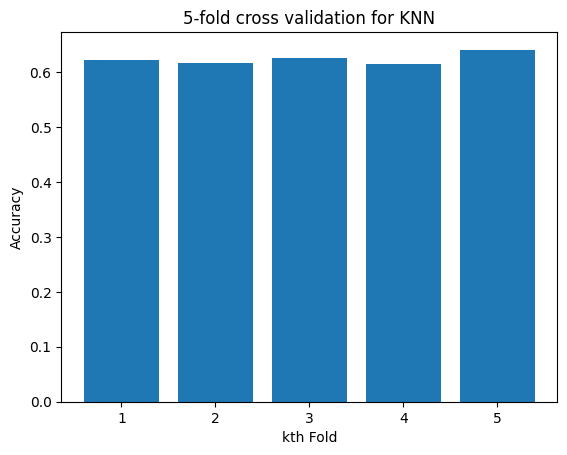

In [97]:
knn = KNeighborsClassifier()
knn=KNeighborsClassifier(n_neighbors=4)
acc=cross_val_score(knn, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for KNN')

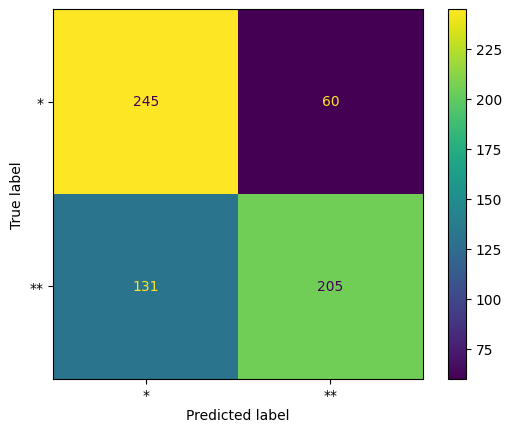

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       305
           1       0.77      0.61      0.68       336

    accuracy                           0.70       641
   macro avg       0.71      0.71      0.70       641
weighted avg       0.72      0.70      0.70       641



In [98]:
clf=KNeighborsClassifier(n_neighbors=4)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### SVC

Text(0.5, 1.0, '5-fold cross validation for SVM')

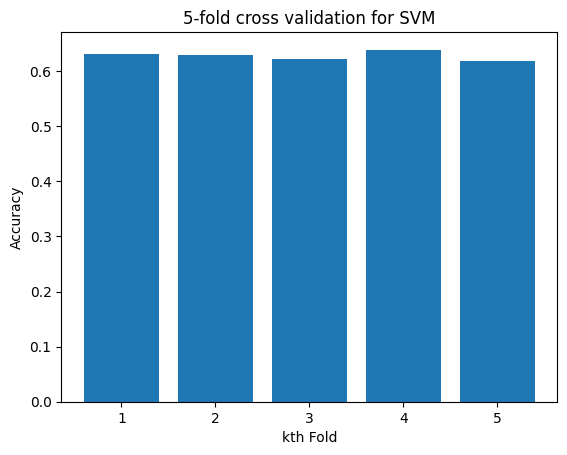

In [99]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf',C=5,gamma='auto')
acc=cross_val_score(clf, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for SVM')

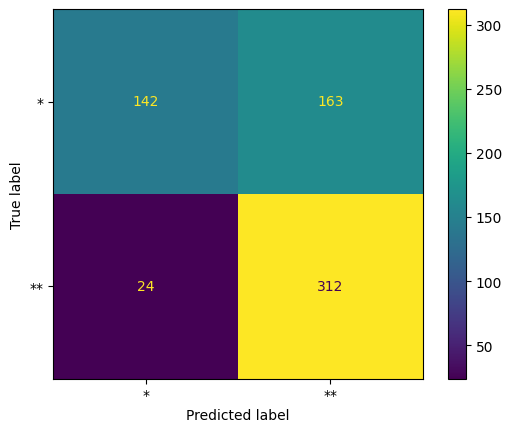

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.86      0.47      0.60       305
           1       0.66      0.93      0.77       336

    accuracy                           0.71       641
   macro avg       0.76      0.70      0.69       641
weighted avg       0.75      0.71      0.69       641



In [100]:
clf=SVC(C=5,gamma='auto')
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### LogisticRegression

Text(0.5, 1.0, '5-fold cross validation for logestic regression')

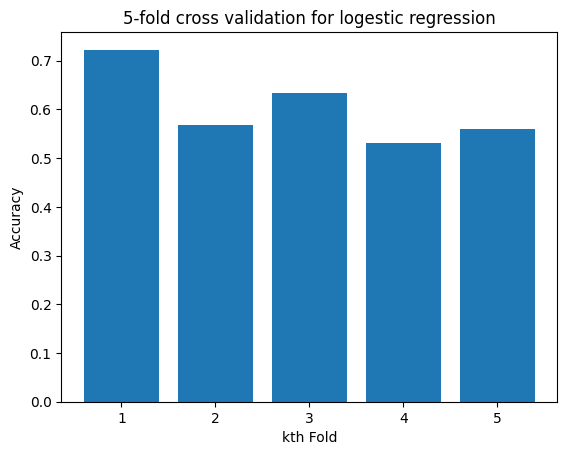

In [101]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=1000)
acc=cross_val_score(clf, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for logestic regression')

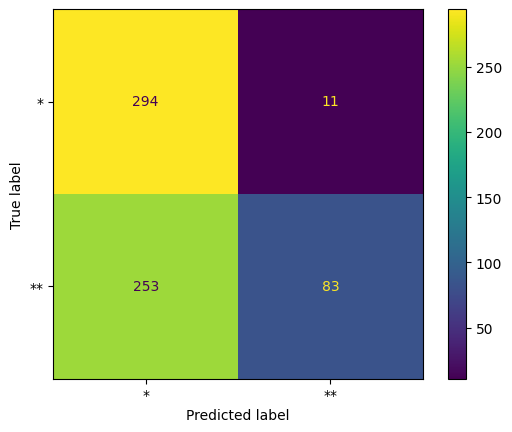

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.54      0.96      0.69       305
           1       0.88      0.25      0.39       336

    accuracy                           0.59       641
   macro avg       0.71      0.61      0.54       641
weighted avg       0.72      0.59      0.53       641



In [102]:
clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### DecisionTree

Text(0.5, 1.0, '5-fold cross validation for Decision Tree')

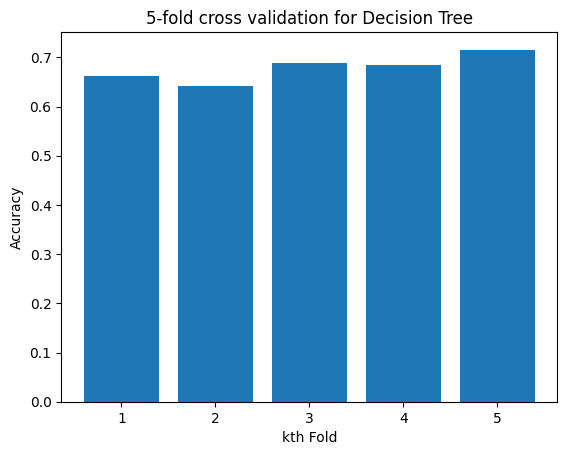

In [103]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=3)
acc=cross_val_score(clf, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for Decision Tree')

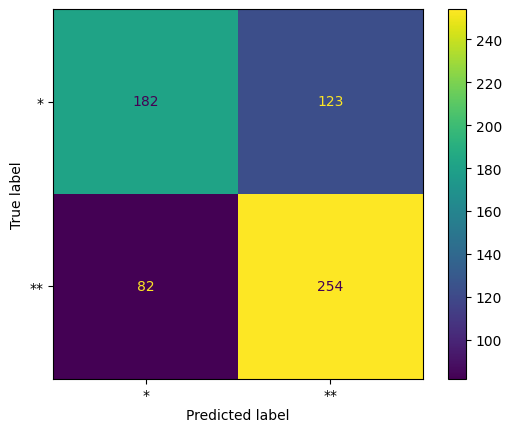

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       305
           1       0.67      0.76      0.71       336

    accuracy                           0.68       641
   macro avg       0.68      0.68      0.68       641
weighted avg       0.68      0.68      0.68       641



In [104]:
clf=DecisionTreeClassifier(max_depth=3)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### RandomForest

Text(0.5, 1.0, '5-fold cross validation for Random forest')

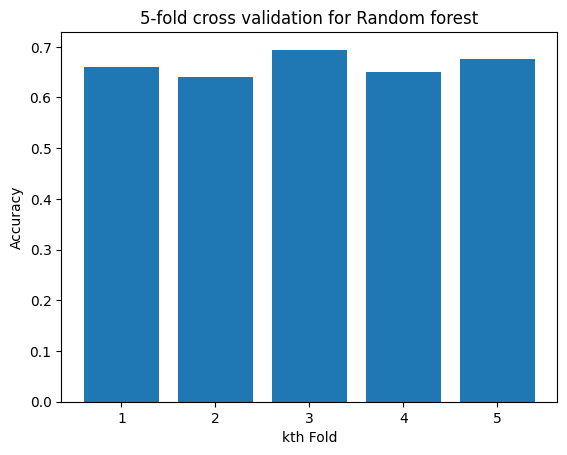

In [105]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=3, random_state=0)
acc=cross_val_score(clf, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for Random forest')

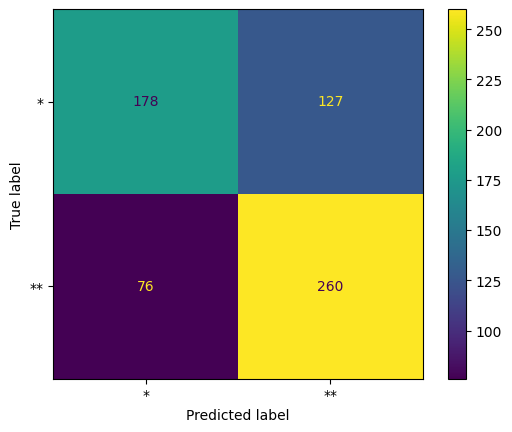

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.70      0.58      0.64       305
           1       0.67      0.77      0.72       336

    accuracy                           0.68       641
   macro avg       0.69      0.68      0.68       641
weighted avg       0.69      0.68      0.68       641



In [106]:
clf = RandomForestClassifier(n_estimators=100,max_depth=3, random_state=0)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### MLP

Text(0.5, 1.0, '5-fold cross validation for MLP')

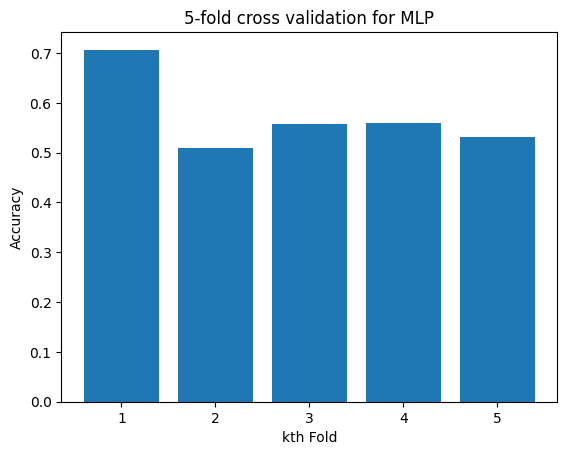

In [107]:
clf = MLPClassifier(hidden_layer_sizes=(50,10),random_state=1, max_iter=300)
acc=cross_val_score(clf, xp, y_bin, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for MLP')

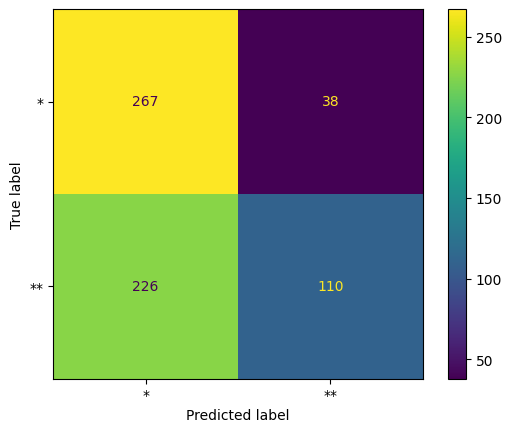

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       305
           1       0.74      0.33      0.45       336

    accuracy                           0.59       641
   macro avg       0.64      0.60      0.56       641
weighted avg       0.65      0.59      0.56       641



In [108]:
clf = MLPClassifier(hidden_layer_sizes=(50,10),random_state=0, max_iter=300)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### Max of SVC, Logisitic Regression, Decision Tree and Knn

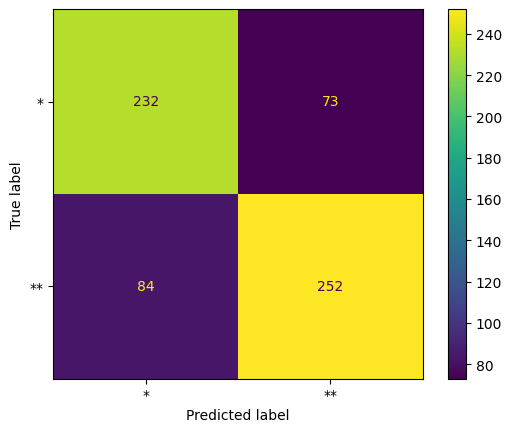

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       305
           1       0.78      0.75      0.76       336

    accuracy                           0.76       641
   macro avg       0.75      0.76      0.75       641
weighted avg       0.76      0.76      0.76       641



In [109]:
clf1=SVC(kernel='rbf',C=1,gamma='auto',probability=True)
clf2=LogisticRegression(random_state=0,max_iter=1000)
clf3=DecisionTreeClassifier(max_depth=3)
clf4=KNeighborsClassifier(n_neighbors=2)
clf4.fit(x_train,y_train)
clf3.fit(x_train,y_train)
clf1.fit(x_train,y_train)
clf2.fit(x_train,y_train)
yp1=clf1.predict_proba(x_test)
yp2=clf2.predict_proba(x_test)
yp3=clf3.predict_proba(x_test)
yp4=clf4.predict_proba(x_test)
y_p=np.argmax((yp1+yp2+yp3+yp4),axis=1)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### AdaBoost


Text(0.5, 1.0, '5-fold cross validation for AdaBoost')

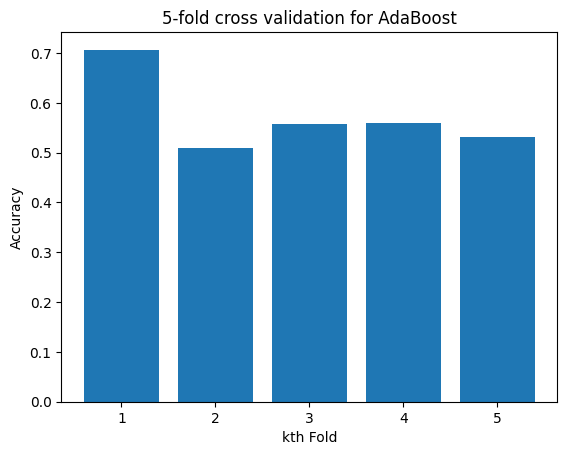

In [110]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=10)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for AdaBoost')

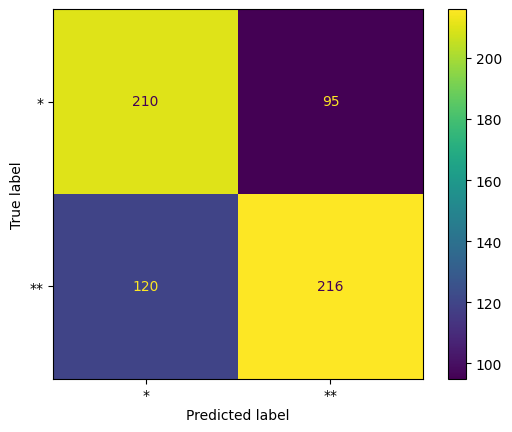

========================Classification Metrics======================
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       305
           1       0.69      0.64      0.67       336

    accuracy                           0.66       641
   macro avg       0.67      0.67      0.66       641
weighted avg       0.67      0.66      0.66       641



In [111]:
clf = AdaBoostClassifier(n_estimators=10)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**'])
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print(classification_report(y_test, y_p, labels=[0,1]))

### B-1) Multi label Classification

In [112]:
startruck_ranges = (0,8,64,np.inf)
startruck_labels = [0, 1,2]
y = datas['stargazers_count']
y_multi = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(xp, y_multi, test_size=0.2, random_state=42)

### KNN


Text(0.5, 1.0, '5-fold cross validation for KNN')

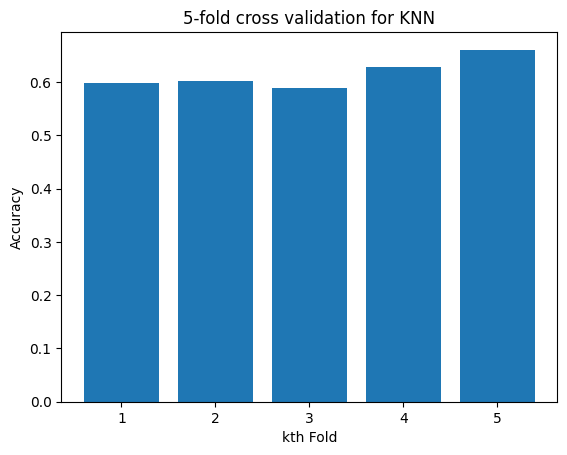

In [114]:
knn = KNeighborsClassifier()
knn=KNeighborsClassifier(n_neighbors=5)
acc=cross_val_score(knn, xp, y_multi, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for KNN')

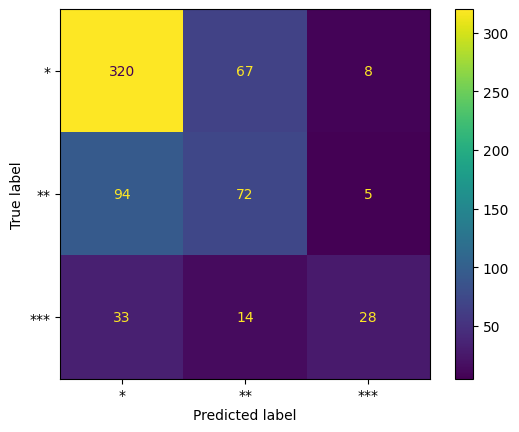

In [115]:
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**','***'])
cm_display.plot()
plt.show()

### SVC

Text(0.5, 1.0, '5-fold cross validation for SVM')

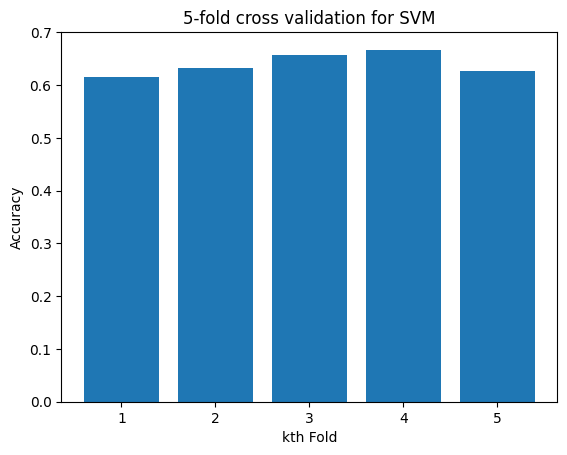

In [116]:
from sklearn.svm import SVC
clf=SVC(C=5,gamma='auto')
acc=cross_val_score(clf, xp, y_multi, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for SVM')

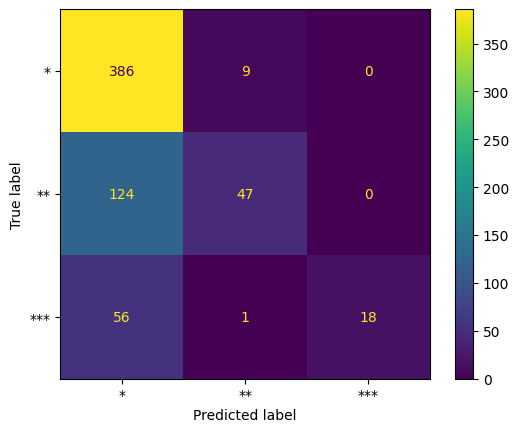

In [117]:
clf=SVC(C=5,gamma='auto')
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**','***'])
cm_display.plot()
plt.show()

### Logistic regression

Text(0.5, 1.0, '5-fold cross validation for logestic regression')

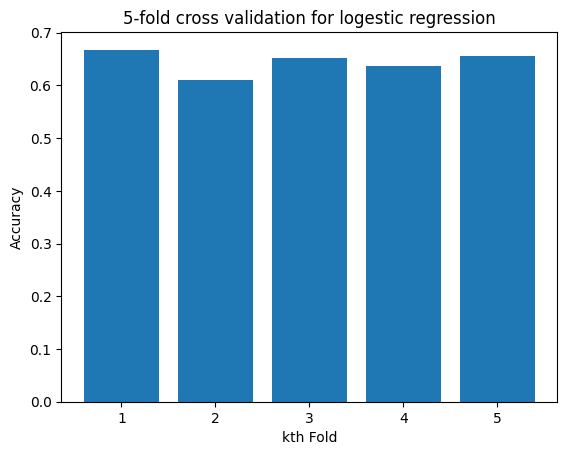

In [118]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=1000)
acc=cross_val_score(clf, xp, y_multi, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for logestic regression')

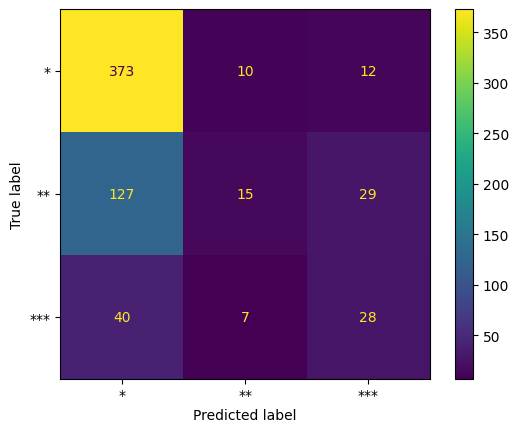

In [119]:
clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**','***'])
cm_display.plot()
plt.show()

### Decision Tree

Text(0.5, 1.0, '5-fold cross validation for Decision Tree')

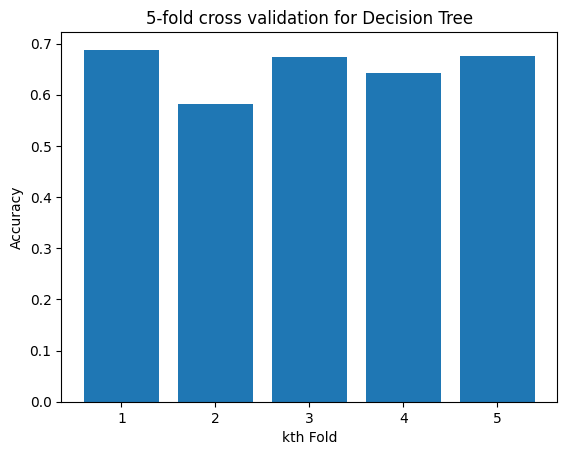

In [120]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=2)
acc=cross_val_score(clf, xp, y_multi, cv=5)
plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for Decision Tree')

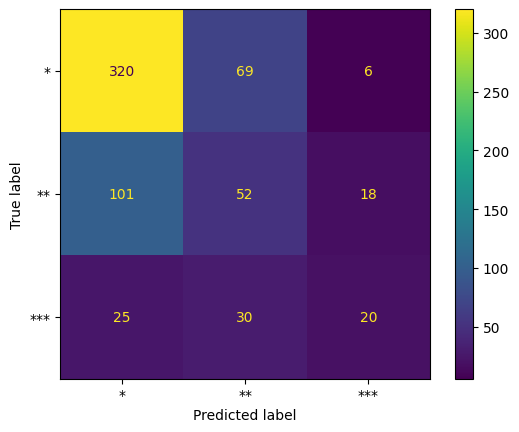

In [121]:
clf=DecisionTreeClassifier(max_depth=2)
clf.fit(x_train,y_train)
y_p=clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['*', '**','***'])
cm_display.plot()
plt.show()